In [177]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../pairedRS')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

In [280]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *

In [281]:
n1, n2 = 100,100
r = 8
prob_obs = 0.5
random_state = 0
allow_inf = False

In [282]:
sampler = PairSampling(n1,n2)
size_obs = n1 * n2 * prob_obs
n_calib_pairs = int(size_obs//4)

In [283]:
mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs

In [284]:
mask_train, idxs_calib, mask_calib, mask_drop = sampler.sample_train_calib(mask_obs, n_calib_pairs, random_state)

In [285]:
RFM = RandomFactorizationModel(n1 ,n2, r)
U, V, M = RFM.sample_noiseless(random_state)

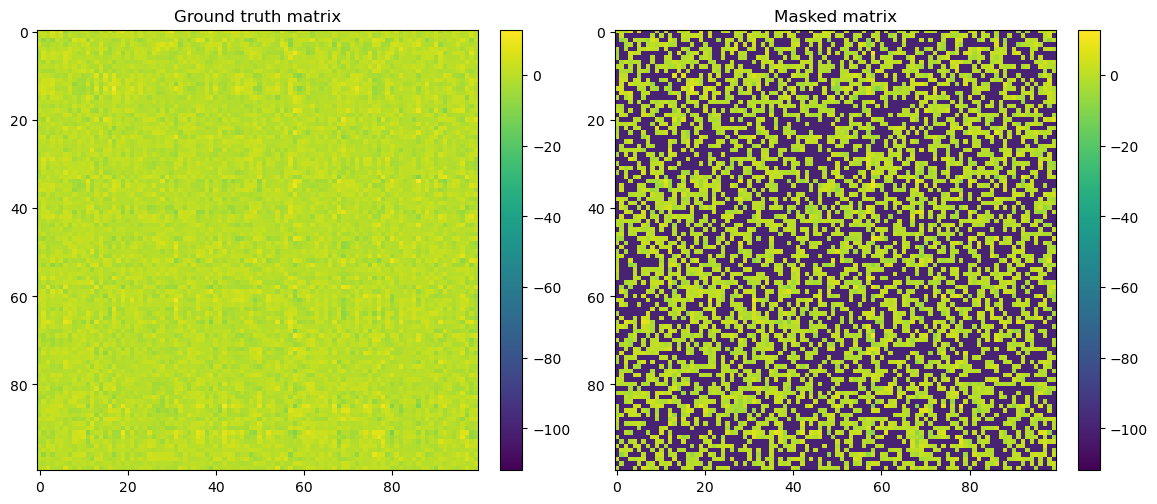

Observation size: 5000.0, training size: 2500.0, calib size: 2500.0, calib pairs: 1250


In [286]:
assert np.all(mask_train+mask_calib==mask_obs),'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}, calib pairs: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_pairs))

In [328]:
def noisy_oracle(M, p, verbose=True, random_state=0):
    rng = np.random.default_rng(random_state)
    
    sd_base = 0.01
    #base = rng.normal(0, sd_base, size=M.shape)
    base = rng.normal(0, sd_base, size=M.shape)
    #noise = rng.normal(0, sd_noise, size=M.shape)
    #noise = rng.standard_t(df, size=M.shape)
    noise = rng.uniform(0.5,1,size=M.shape)
    
    n1 = M.shape[0]
    n2 = M.shape[1]
    
    # even numbered rows are likely to have higher noise
    noise_loc = np.zeros_like(M)
    for i in range(1, n1, 2):
        noise_loc[i, :] = rng.binomial(1, p, n2)
    
    return M + base + noise*noise_loc

In [ ]:
def noise_model(M, p, random_state=0):
    

In [329]:
Mhat =  noisy_oracle(M, p=0.9, verbose=True, random_state=0)

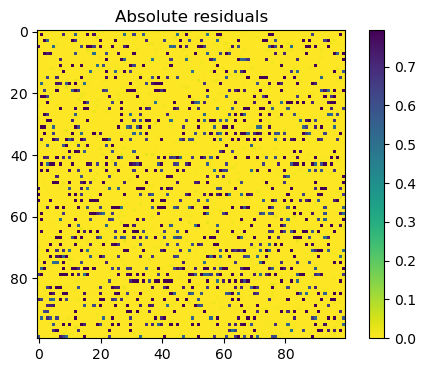

In [330]:
# some rows have larger residuals
error_heatmap(M, Mhat, mask_calib)

In [331]:
# Sample test pairs
n_test_pairs = min(int((np.sum(mask_test)-n1)//2), 1000)
_, idxs_test, _, _ = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)

In [332]:
methods = [
    "conformal",
    "naive",
    "bonferroni",
    "uncorrected"
]

In [333]:
res = pd.DataFrame({})

for method in methods:
    is_inf = np.zeros(n_test_pairs)
    if method == "conformal":
        ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
        lower, upper, is_inf, _ = ci_method.get_CI(idxs_test, alpha, allow_inf)
    elif method == "naive":
        ci_method = PairedCI_hpm(M, Mhat, mask_obs, idxs_calib)
        lower, upper = ci_method.naive_CI(idxs_test, alpha)       
    elif method == "bonferroni":
        lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha)
    else:
        lower, upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, 2 * alpha)

    res = pd.concat([res, evaluate_pairedCI(lower, upper, M, idxs_test, is_inf=is_inf, method=method)])
    
res['Calib_size'] = n_calib_pairs
res['Train_size'] = np.sum(mask_train)
res['Test_size'] = n_test_pairs

Computing conformal prediction intervals for 1000 test pairs...


CI: 100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.40it/s]

Done!
Computing naive prediction intervals for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.1 for 1000 test pairs...
Done!
Computing prediction intervals with Bonferroni correction with alpha 0.2 for 1000 test pairs...
Done!


In [334]:
res

,Pair_coverage,Coverage,Size,Inf_prop,Method,Calib_size,Train_size,Test_size
0,0.894,0.945,1.873267,0.0,conformal,1250,2500.0,1000
0,0.894,0.945,1.874692,0.0,naive,1250,2500.0,1000
0,0.901,0.949,1.881872,0.0,bonferroni,1250,2500.0,1000
0,0.838,0.912,1.792568,0.0,uncorrected,1250,2500.0,1000


In [335]:
st_pair_scores = ci_method.st_calib_scores
conformal_st = np.quantile(st_pair_scores, 1 - alpha, method="lower")

In [336]:
scores = np.abs((M-Mhat)[np.where(mask_calib==1)])

In [337]:
bon_st, st_scores = get_bon_st(scores, alpha)

Paired quantile is 0.9373457833907712, Bonferroni quantile is 0.9409359536355892


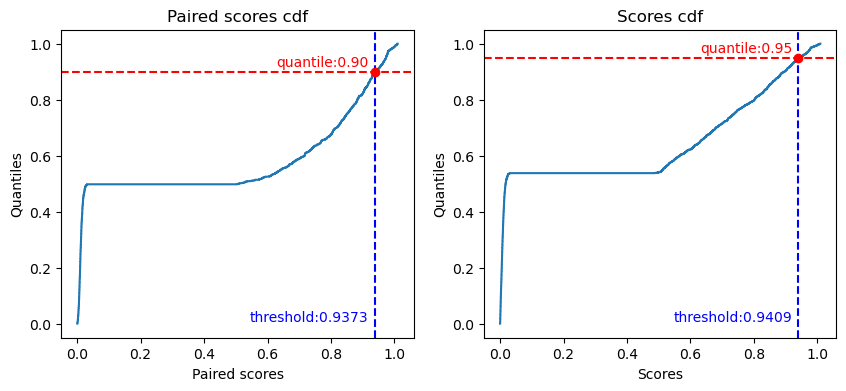

In [338]:
plot_st(st_pair_scores, st_scores, conformal_st, bon_st, len(st_scores), alpha)

In [37]:
def get_scores(model, n, random_state=0):  
    rng = np.random.default_rng(random_state)
    
    if model == "uniform":  
        scores = rng.uniform(0,1,n)
    if model == "normal":
        scores = np.abs(rng.normal(0,1,n))
    return scores

In [38]:
# Bonferroni
def get_bon_st(scores, alpha):
    st_scores = np.sort(scores)
    alpha_corrected = alpha / 2
    bon_st = np.quantile(st_scores, 1 - alpha_corrected, method="lower")
    return bon_st, st_scores

In [49]:
def get_conformal_st(scores, alpha, pair_method):
    if pair_method == "indep":
        # pairs are picked at random
        pairs = [[scores[2*i], scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    elif pair_method == "pos_cor":
        # similar scores are grouped
        st_scores = np.sort(scores)
        pairs = [[st_scores[2*i], st_scores[2*i+1]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
    
    elif pair_method == "neg_cor":
        st_scores = np.sort(scores)
        pairs = [[st_scores[i], st_scores[-(i+1)]] for i in range(n//2)]
        pair_scores = [np.max(p) for p in pairs]
        
    st_pair_scores = np.sort(pair_scores)
    conformal_st = np.quantile(st_pair_scores, 1 - alpha, method="lower")
    return st_pair_scores, conformal_st

In [275]:
def plot_st(st_pair_scores, st_scores, conformal_st, bon_st, n, alpha):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    px = np.arange(1, n//2 + 1) / (n//2)
    h_spacing = bon_st/50
    v_spacing = alpha/5
    
    ax[0].step(st_pair_scores, px, label='Paired CDF', where='post')
    ax[0].axhline(y=1-alpha, color='red', linestyle='--')
    ax[0].axvline(x=conformal_st, color='blue', linestyle='--')
    ax[0].set_title("Paired scores cdf")
    ax[0].set_xlabel("Paired scores")
    ax[0].set_ylabel("Quantiles")
    ax[0].plot(conformal_st, 1-alpha, 'ro')
    ax[0].annotate(f'threshold:{conformal_st:.4f}', (conformal_st-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[0].annotate(f'quantile:{1-alpha:.2f}', (conformal_st-h_spacing, 1-alpha+v_spacing), fontsize=10, color='red', ha='right')

    x = np.arange(1, n + 1) / n
    ax[1].step(st_scores, x, label='CDF', where='post')
    ax[1].axhline(y=1-alpha/2, color='red', linestyle='--', label='Vertical Line')
    ax[1].axvline(x=bon_st, color='blue', linestyle='--')
    ax[1].set_title("Scores cdf")
    ax[1].set_xlabel("Scores")
    ax[1].set_ylabel("Quantiles")
    ax[1].plot(bon_st, 1-alpha/2, 'ro')
    ax[1].annotate(f'threshold:{bon_st:.4f}', (bon_st-h_spacing, 0.01), fontsize=10, color='blue', ha='right')
    ax[1].annotate(f'quantile:{1-alpha/2:.2f}', (bon_st-h_spacing, 1-alpha/2+v_spacing), fontsize=10, color='red', ha='right')

    print("Paired quantile is {}, Bonferroni quantile is {}".format(conformal_st, bon_st))

In [276]:
n = 1000
alpha = 0.1
pair_method = "pos_cor"
model = "normal"
seed = 0

scores =  get_scores(model, n, random_state=seed)
st_pair_scores, conformal_st = get_conformal_st(scores, alpha, pair_method)
bon_st, st_scores = get_bon_st(scores, alpha)

Paired quantile is 1.5290928749284465, Bonferroni quantile is 1.8829080367785338


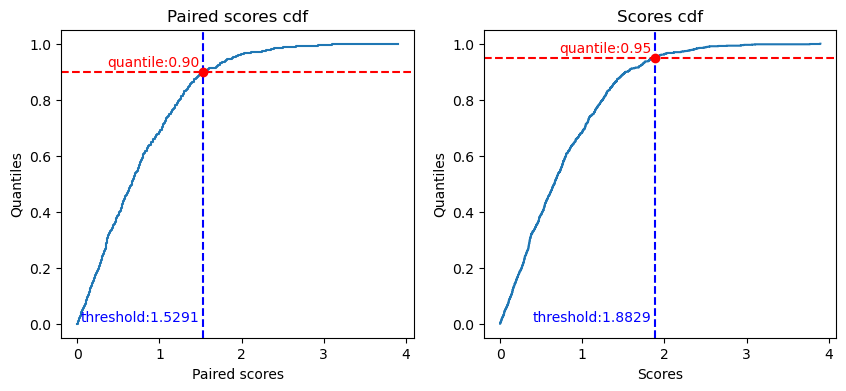

In [277]:
plot_st(st_pair_scores, st_scores, conformal_st, bon_st, n, alpha)